Reproduire [Active learning](https://github.com/lunayht/DBALwithImgData/tree/main?tab=readme-ov-file)
avec des [images de dechets](https://archive.ics.uci.edu/dataset/908/realwaste)

expérience realisée en local : RTX3060

[nb](https://colab.research.google.com/drive/1NUgaFo2liAhfBNFZHyyJ1B5L1Wk2bnNr?usp=sharing#scrollTo=ICiCuHD0Ffu7)

# Imports 

In [3]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import random
import seaborn as sns
import time


from PIL import Image
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision import models
from torchvision.datasets import ImageFolder

from scipy import stats
from scipy.ndimage import gaussian_filter1d
from skorch import NeuralNetClassifier
from modAL.models import ActiveLearner

from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

In [13]:
import warnings
warnings.filterwarnings("ignore", message="'force_all_finite' was renamed to 'ensure_all_finite'")

In [14]:
# 1. Définir le chemin vers le dossier racine des données
data_dir = '../RealWaste_Augmented'

# 1. Augmentation de Données Stratégique

L'objectif est de créer un jeu de données augmenté et équilibré en deux étapes :

1.  **Augmentation de Base** : Une copie de chaque image originale est conservée, et une version retournée horizontalement (`flipped`) est créée pour toutes les classes. Cela double la taille initiale du jeu de données.
2.  **Équilibrage par Augmentation Forte** : Pour les classes sous-représentées, des transformations plus fortes (rotations, variations de couleur) sont appliquées pour générer de nouvelles images jusqu'à ce que chaque classe atteigne le même nombre d'images que la classe la plus peuplée.

In [20]:
# Définir les chemins
data_dir = '../RealWaste'  # Dossier contenant les images originales
augmented_data_dir = '../RealWaste_Augmented' # Dossier où sauvegarder les images augmentées

# Créer le dossier de destination s'il n'existe pas
if not os.path.exists(augmented_data_dir):
    os.makedirs(augmented_data_dir)

print(f"Les images originales se trouvent dans : {data_dir}")
print(f"Les images augmentées seront sauvegardées dans : {augmented_data_dir}")

Les images originales se trouvent dans : ../RealWaste
Les images augmentées seront sauvegardées dans : ../RealWaste_Augmented


In [ ]:

# --- Définition des transformations améliorées ---

# Transformations de base (appliquées à toutes les images)
base_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),  # Probabilité réduite
])

# Transformations fortes pour l'équilibrage (plus contrôlées)
strong_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomAffine(
        degrees=15,  # Rotation modérée
        translate=(0.05, 0.05),  # Translation réduite
        scale=(0.95, 1.05),  # Zoom léger
        shear=5,  # Cisaillement réduit
        fill=0  # Remplissage noir pour les zones vides
    ),
    transforms.ColorJitter(
        brightness=0.15,
        contrast=0.15,
        saturation=0.1,
        hue=0.05
    ),
    transforms.RandomHorizontalFlip(p=0.3),  # Moins agressif
    transforms.CenterCrop(224),
]
)

# --- Étape 1: Augmentation de base améliorée ---

def initial_augmentation(source_dir, dest_dir):
    """Applique une augmentation de base plus intelligente"""
    class_names = [d for d in os.listdir(source_dir) if os.path.isdir(os.path.join(source_dir, d))]
    
    for class_name in tqdm(class_names, desc="Étape 1: Augmentation de base"):
        source_class_path = os.path.join(source_dir, class_name)
        dest_class_path = os.path.join(dest_dir, class_name)
        if not os.path.exists(dest_class_path):
            os.makedirs(dest_class_path)

        image_files = [f for f in os.listdir(source_class_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

        for image_name in image_files:
            source_image_path = os.path.join(source_class_path, image_name)
            try:
                image = Image.open(source_image_path).convert("RGB")
            except Exception as e:
                print(f"Erreur lors du chargement de {image_name}: {e}")
                continue

            # Sauvegarder l'originale (redimensionnée)
            original_resized = image.resize((224, 224), Image.Resampling.LANCZOS)
            original_resized.save(os.path.join(dest_class_path, image_name))

            # Appliquer le flip avec probabilité (pas systématique)
            if random.random() < 0.7:  # 70% de chance de créer une version flippée
                flipped_image = original_resized.transpose(Image.FLIP_LEFT_RIGHT)
                base_name, ext = os.path.splitext(image_name)
                flipped_image.save(os.path.join(dest_class_path, f"{base_name}_flip{ext}"))

# --- Étape 2: Équilibrage avec transformations contrôlées ---

def balance_with_strong_augmentation(data_dir, balance_ratio=0.8):
    """Équilibrage avec des transformations plus sophistiquées"""
    class_counts = {c: len(os.listdir(os.path.join(data_dir, c))) 
                   for c in os.listdir(data_dir) 
                   if os.path.isdir(os.path.join(data_dir, c))}
    
    max_count = max(class_counts.values())
    target_count = int(max_count * balance_ratio)
    
    print(f"\nDistribution avant équilibrage: {class_counts}")
    print(f"Objectif par classe: {target_count} images ({int(balance_ratio*100)}% de la classe majoritaire)")

    for class_name, count in tqdm(class_counts.items(), desc="Étape 2: Équilibrage"):
        if count < target_count:
            num_to_generate = target_count - count
            class_path = os.path.join(data_dir, class_name)
            image_files = [f for f in os.listdir(class_path) 
                          if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
            
            # Éviter de toujours utiliser les mêmes images sources
            random.shuffle(image_files)
            
            for i in range(num_to_generate):
                # Sélection cyclique pour équilibrer l'usage des images sources
                source_image_name = image_files[i % len(image_files)]
                image_path = os.path.join(class_path, source_image_name)
                
                try:
                    image = Image.open(image_path).convert("RGB")
                except Exception as e:
                    print(f"Erreur lors du chargement de {source_image_name}: {e}")
                    continue
                
                # Appliquer les transformations fortes avec torchvision
                try:
                    # Convertir PIL en tensor temporairement pour les transformations
                    augmented_image = strong_transforms(image)
                    
                    # Sauvegarder l'image augmentée
                    base_name, ext = os.path.splitext(source_image_name)
                    new_image_name = f"{base_name}_strong_aug_{i+1}{ext}"
                    augmented_image.save(os.path.join(class_path, new_image_name))
                    
                except Exception as e:
                    print(f"Erreur lors de l'augmentation de {source_image_name}: {e}")
                    continue

# --- Fonction de validation pour vérifier la qualité ---

def validate_augmentation_quality(data_dir, num_samples_per_class=3):
    """Affiche quelques exemples pour vérifier la qualité des augmentations"""
    print("\n--- Validation de la qualité des augmentations ---")
    
    class_names = [d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))]
    
    for class_name in class_names:
        class_path = os.path.join(data_dir, class_name)
        augmented_files = [f for f in os.listdir(class_path) 
                          if 'aug' in f and f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        
        if augmented_files:
            sample_files = random.sample(augmented_files, 
                                       min(num_samples_per_class, len(augmented_files)))
            print(f"Classe '{class_name}': {len(augmented_files)} images augmentées générées")
            for sample in sample_files:
                print(f"  - {sample}")

# --- Fonction principale d'exécution ---

def run_complete_augmentation(source_dir, dest_dir, balance_ratio=0.8):
    """Lance le processus complet d'augmentation"""
    
    # Étape 1: Augmentation de base
    print("🔄 Début de l'augmentation de base...")
    initial_augmentation(source_dir, dest_dir)
    print("✅ Étape 1 terminée.")
    
    # Étape 2: Équilibrage
    print("\n🎯 Début de l'équilibrage...")
    balance_with_strong_augmentation(dest_dir, balance_ratio)
    
    # Calcul des statistiques finales
    final_counts = {c: len(os.listdir(os.path.join(dest_dir, c))) 
                   for c in os.listdir(dest_dir) 
                   if os.path.isdir(os.path.join(dest_dir, c))}
    
    print(f"\n📊 Distribution finale: {final_counts}")
    print("✅ Processus d'augmentation terminé.")
    
    # Validation de la qualité
    validate_augmentation_quality(dest_dir)



In [28]:
# --- Utilisation ---
# Remplacez par vos chemins réels
run_complete_augmentation(data_dir, augmented_data_dir, balance_ratio=0.8)

🔄 Début de l'augmentation de base...


Étape 1: Augmentation de base: 100%|██████████| 9/9 [00:31<00:00,  3.52s/it]


✅ Étape 1 terminée.

🎯 Début de l'équilibrage...

Distribution avant équilibrage: {'Cardboard': 774, 'Food Organics': 703, 'Glass': 723, 'Metal': 1359, 'Miscellaneous Trash': 837, 'Paper': 855, 'Plastic': 1580, 'Textile Trash': 538, 'Vegetation': 737}
Objectif par classe: 1264 images (80% de la classe majoritaire)


Étape 2: Équilibrage: 100%|██████████| 9/9 [01:27<00:00,  9.68s/it]


📊 Distribution finale: {'Cardboard': 1264, 'Food Organics': 1264, 'Glass': 1264, 'Metal': 1359, 'Miscellaneous Trash': 1264, 'Paper': 1264, 'Plastic': 1580, 'Textile Trash': 1264, 'Vegetation': 1264}
✅ Processus d'augmentation terminé.

--- Validation de la qualité des augmentations ---
Classe 'Cardboard': 490 images augmentées générées
  - Cardboard_231_strong_aug_359.jpg
  - Cardboard_352_flip_strong_aug_118.jpg
  - Cardboard_402_flip_strong_aug_14.jpg
Classe 'Food Organics': 561 images augmentées générées
  - Food Organics_182_flip_strong_aug_213.jpg
  - Food Organics_173_flip_strong_aug_107.jpg
  - Food Organics_313_flip_strong_aug_236.jpg
Classe 'Glass': 541 images augmentées générées
  - Glass_165_strong_aug_337.jpg
  - Glass_161_flip_strong_aug_462.jpg
  - Glass_205_strong_aug_110.jpg
Classe 'Miscellaneous Trash': 427 images augmentées générées
  - Miscellaneous Trash_294_strong_aug_245.jpg
  - Miscellaneous Trash_488_flip_strong_aug_333.jpg
  - Miscellaneous Trash_228_strong_a

# Load data 

In [11]:
def tensor_to_np(tensor_data: torch.Tensor) -> np.ndarray:
    """
    Since Skorch doesn not support dtype of torch.Tensor, we will modify
    the dtype to numpy.ndarray
    Attribute:
        tensor_data: Data of class type=torch.Tensor
    """
    np_data = tensor_data.detach().numpy()
    return np_data

In [12]:
# 2. Définir les transformations pour les images
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),      
    transforms.ToTensor(),               
])

In [15]:

if os.path.isdir(data_dir):
    realwaste_dataset = ImageFolder(root=data_dir, transform=data_transforms)

    print(f"Nombre total d'images trouvées : {len(realwaste_dataset)}")
    print(f"Classes trouvées : {realwaste_dataset.classes}")
    print(f"Mapping classe -> index : {realwaste_dataset.class_to_idx}")

    batch_size = 32 
    realwaste_dataloader = DataLoader(realwaste_dataset, batch_size=batch_size, shuffle=True, num_workers=0) 

    try:
        images, labels = next(iter(realwaste_dataloader))        
    except StopIteration:
        print("\nLe DataLoader est vide (aucune image chargée).")
    except Exception as e:
        print(f"\nErreur lors de la récupération d'un lot : {e}")

else:
    print(f"Le dossier spécifié n'existe pas : {data_dir}")


Nombre total d'images trouvées : 11787
Classes trouvées : ['Cardboard', 'Food Organics', 'Glass', 'Metal', 'Miscellaneous Trash', 'Paper', 'Plastic', 'Textile Trash', 'Vegetation']
Mapping classe -> index : {'Cardboard': 0, 'Food Organics': 1, 'Glass': 2, 'Metal': 3, 'Miscellaneous Trash': 4, 'Paper': 5, 'Plastic': 6, 'Textile Trash': 7, 'Vegetation': 8}


In [16]:
# Create a mapping from index to class name
idx_to_class = {v: k for k, v in realwaste_dataset.class_to_idx.items()}

Number of images in each category:
Cardboard: 1264 images
Food Organics: 1264 images
Glass: 1264 images
Metal: 1359 images
Miscellaneous Trash: 1264 images
Paper: 1264 images
Plastic: 1580 images
Textile Trash: 1264 images
Vegetation: 1264 images


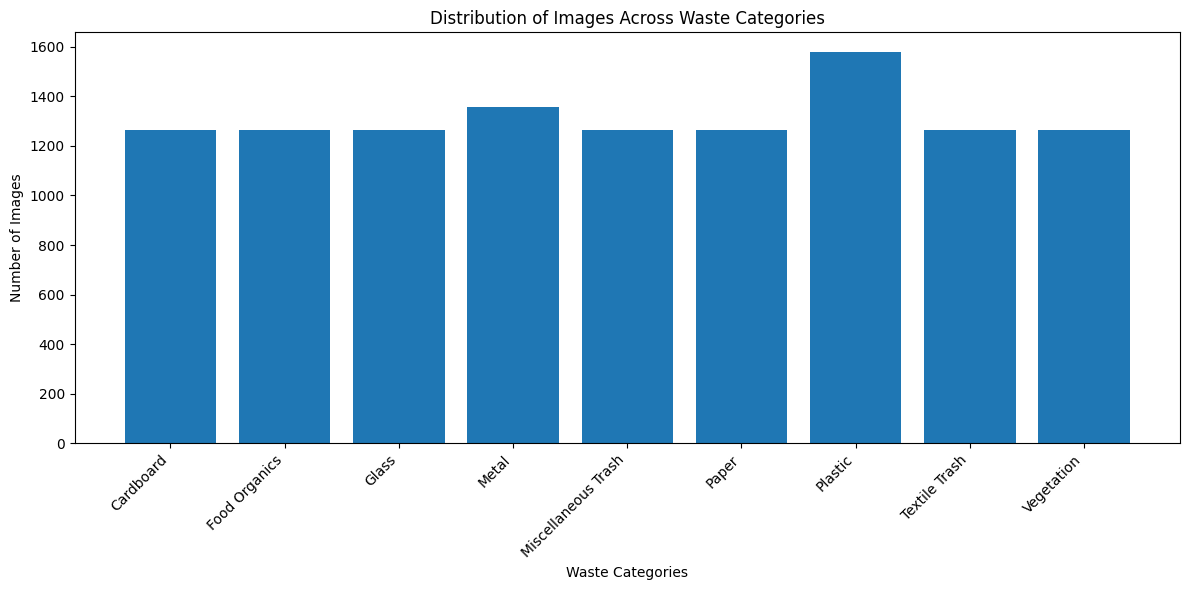

In [17]:
# Count the number of images per class
class_counts = {}
for img_path, class_idx in realwaste_dataset.samples:
    class_name = idx_to_class[class_idx]  # Récupère le nom de la classe à partir de l'index
    if class_name in class_counts:
        class_counts[class_name] += 1     # Incrémente le compteur pour la classe
    else:
        class_counts[class_name] = 1      # Initialise le compteur pour la classe

# Trie le dictionnaire par nom de classe pour une meilleure lisibilité
sorted_class_counts = {k: class_counts[k] for k in sorted(class_counts.keys())}

# Affiche le nombre d'images dans chaque catégorie
print("Number of images in each category:")
for class_name, count in sorted_class_counts.items():
    print(f"{class_name}: {count} images")

# Crée un graphique en barres pour visualiser la distribution
plt.figure(figsize=(12, 6))
plt.bar(sorted_class_counts.keys(), sorted_class_counts.values())  # Barres pour chaque classe
plt.xlabel('Waste Categories')  # Légende de l'axe x
plt.ylabel('Number of Images')  # Légende de l'axe y
plt.title('Distribution of Images Across Waste Categories')  # Titre du graphique
plt.xticks(rotation=45, ha='right')  # Rotation des labels pour lisibilité
plt.tight_layout()  # Ajuste la disposition
plt.show()  # Affiche le graphique

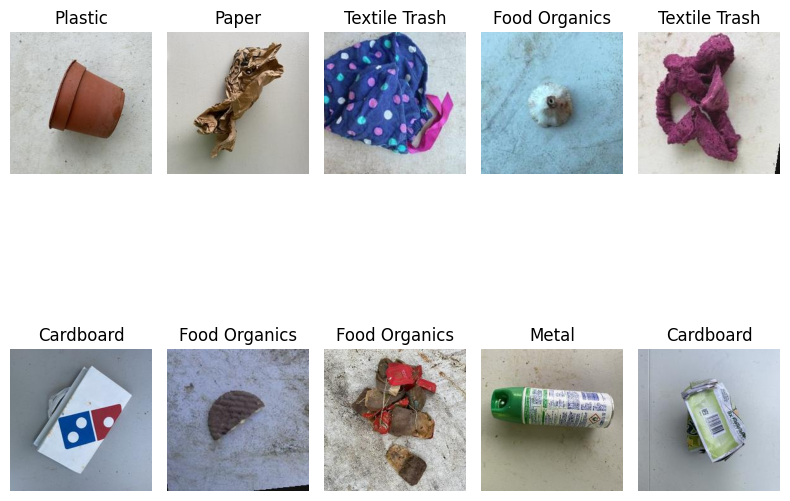

In [18]:
# Create a figure to display images
fig, axes = plt.subplots(2, 5, figsize=(8, 8))
axes = axes.flatten()

# Display up to 32 images
for i in range(min(10, len(images))):
    img = images[i].permute(1, 2, 0).cpu().numpy()
    class_name = idx_to_class[labels[i].item()]
    
    axes[i].imshow(img)
    axes[i].set_title(class_name)
    axes[i].axis('off')

# Hide any unused subplots
for i in range(len(images), len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()

Dans l'article, il est question de modèle de classification binaire, dans notre cas nous allons essayer d'implementer cette architechture avec un modèle de classification a classe multiples 

# Split Data

In [19]:
#split the dataset into training and testing sets
all_data = []
all_labels = []

In [20]:
all_data, all_labels = zip(*(realwaste_dataset[i] for i in range(len(realwaste_dataset))))
all_data = list(all_data)
all_labels = list(all_labels)

In [21]:
# Conversion en tenseurs
all_data = torch.stack(all_data)
all_labels = torch.tensor(all_labels)

In [22]:
# Conversion en numpy arrays
X_data = tensor_to_np(all_data)
y_labels = tensor_to_np(all_labels)

In [23]:
# utiliser un sous ensemble des données pour le prototypage
sample_size = 1000 
indices = np.random.choice(range(len(all_data)), size=sample_size, replace=False)

In [24]:
X_data_sample = X_data[indices]
y_labels_sample = y_labels[indices]

In [25]:
# repartition des classes dans le sous ensemble
class_counts_sample = {}
for label in y_labels_sample:
    class_name = idx_to_class[label]
    if class_name in class_counts_sample:
        class_counts_sample[class_name] += 1
    else:
        class_counts_sample[class_name] = 1

In [26]:
# faire un split stratifié en fonction des classes
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42, train_size=sample_size)

In [27]:
for i, (train_index, test_index) in enumerate(sss.split(X_data, y_labels)):
    X_data_sample_stratified = X_data[train_index]
    y_labels_sample_stratified= y_labels[train_index]

In [28]:
class_counts_sample_strat = {}
for label in y_labels_sample_stratified:
    class_name = idx_to_class[label]
    if class_name in class_counts_sample_strat:
        class_counts_sample_strat[class_name] += 1
    else:
        class_counts_sample_strat[class_name] = 1

In [29]:

class_counts_sample_sorted = {k: class_counts_sample[k] for k in sorted(class_counts_sample.keys())}
class_counts_sample_strat_sorted = {k: class_counts_sample_strat[k] for k in sorted(class_counts_sample_strat.keys())}

In [30]:
print(class_counts_sample_sorted)
print(class_counts_sample_strat_sorted)

{'Cardboard': 105, 'Food Organics': 108, 'Glass': 125, 'Metal': 114, 'Miscellaneous Trash': 100, 'Paper': 103, 'Plastic': 147, 'Textile Trash': 93, 'Vegetation': 105}
{'Cardboard': 108, 'Food Organics': 107, 'Glass': 107, 'Metal': 116, 'Miscellaneous Trash': 107, 'Paper': 107, 'Plastic': 134, 'Textile Trash': 107, 'Vegetation': 107}


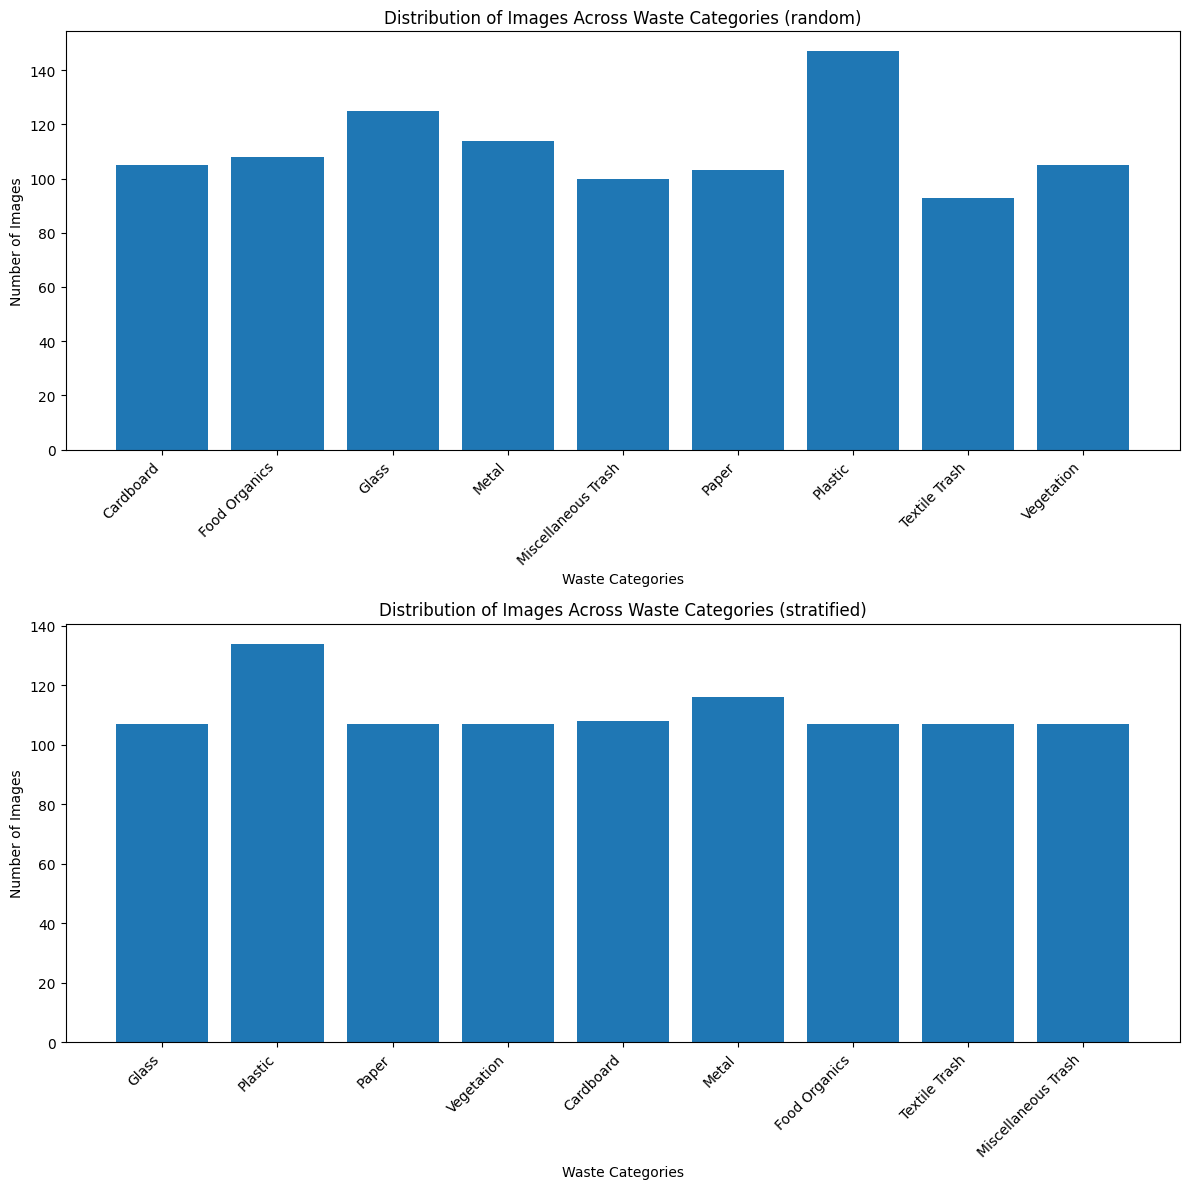

In [31]:
# plot deux bar graphes, un au dessus de l'autre pour comparer 
plt.figure(figsize=(12, 12))
plt.subplot(2, 1, 1)  
plt.bar(class_counts_sample_sorted.keys(), class_counts_sample_sorted.values())
plt.xlabel('Waste Categories')  
plt.ylabel('Number of Images')
plt.title('Distribution of Images Across Waste Categories (random)')
plt.xticks(rotation=45, ha='right')
plt.subplot(2, 1, 2)
plt.bar(class_counts_sample_strat.keys(), class_counts_sample_strat.values())
plt.xlabel('Waste Categories')
plt.ylabel('Number of Images')
plt.title('Distribution of Images Across Waste Categories (stratified)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout() 

Meme si la repartition des classes dans le sample cree de maniere aleatoire, elle respecte relativement la répartition des classes, je vais continuer avec le sous ensemble stratifié pour mieux reproduire l'expérience 

In [32]:
X_temp, X_test, y_temp, y_test = train_test_split(
    X_data_sample_stratified, 
    y_labels_sample_stratified, 
    test_size=0.2,     
    random_state=50,    
    stratify=y_labels_sample   
)

In [33]:
X_temp.shape, y_temp.shape

((800, 3, 224, 224), (800,))

In [34]:
X_train, X_validation, y_train, y_validation = train_test_split(
    X_temp,
    y_temp,
    test_size=0.2,     
    random_state=42,
    stratify=y_temp
)

In [35]:
# Compter le nombre d'occurrences de chaque classe dans une liste numpy
def count_class_occurrences(y_array):
    unique, counts = np.unique(y_array, return_counts=True)
    return dict(zip(unique, counts))

In [36]:
# repartition eauilibrée des classes dans le sous ensemble de validation
occurrences_y_val = count_class_occurrences(y_validation)
nb_par_classes = {f"classe {idx_to_class[k]}": int(v) for k, v in occurrences_y_val.items()}
print(nb_par_classes)

{'classe Cardboard': 17, 'classe Food Organics': 17, 'classe Glass': 17, 'classe Metal': 19, 'classe Miscellaneous Trash': 18, 'classe Paper': 17, 'classe Plastic': 23, 'classe Textile Trash': 16, 'classe Vegetation': 16}


In [37]:
def select_n_per_class(X, y, n_per_class, seed=350):
    """
    Sélectionne n_per_class indices par classe de façon aléatoire.
    """
    np.random.seed(seed)
    selected_indices = []
    y = np.array(y)
    classes = np.unique(y)
    for c in classes:
        idx = np.where(y == c)[0]
        if len(idx) < n_per_class:
            raise ValueError(f"Pas assez d'images pour la classe {c} (trouvé {len(idx)}, requis {n_per_class})")
        chosen = np.random.choice(idx, size=n_per_class, replace=False)
        selected_indices.extend(chosen)
    return np.array(selected_indices)


In [38]:
# Sélectionner un sous-ensemble initial de données pour l'apprentissage actif
# Dans le papier, 20 images par classe sont utilisées pour commencer l'apprentissage actif
IMG_PER_CLASS=20
initial_idx = select_n_per_class(X_train, y_train, n_per_class=IMG_PER_CLASS)
X_initial, y_initial = X_train[initial_idx], y_train[initial_idx]
X_pool = np.delete(X_train, initial_idx, axis=0)
y_pool = np.delete(y_train, initial_idx, axis=0)

# Acquisition functions 

In [37]:
def predictions_from_pool(
    model, 
    X_pool: np.ndarray, 
    T: int = 100, 
    training: bool = True
):
    """
    Run random_subset prediction on model and return the output
    Attributes:
        X_pool: Pool set to select uncertainty,
        T: Number of MC dropout iterations aka training iterations,
        training: If False, run test without MC dropout. (default=True)
    """
    subset_size = min(500, len(X_pool))
    random_subset = np.random.choice(range(len(X_pool)), size=subset_size, replace=False)
    with torch.no_grad():
        outputs = np.stack(
            [
                torch.softmax(
                    model.estimator.forward(X_pool[random_subset], training=training),
                    dim=-1,
                )
                .cpu()
                .numpy()
                for _ in range(T)
            ]
        )
    return outputs, random_subset

In [38]:
def shannon_entropy_function(
    model, 
    X_pool: np.ndarray, 
    T: int = 100, 
    E_H: bool = False, 
    training: bool = True
):
    """
    H[y|x,D_train] := - sum_{c} p(y=c|x,D_train)log p(y=c|x,D_train)
    Attributes:
        model: Model that is ready to measure uncertainty after training,
        X_pool: Pool set to select uncertainty,
        T: Number of MC dropout iterations aka training iterations,
        E_H: If True, compute H and EH for BALD (default: False),
        training: If False, run test without MC dropout. (default=True)
    """
    outputs, random_subset = predictions_from_pool(model, X_pool, T, training=training)
    pc = outputs.mean(axis=0)
    H = (-pc * np.log(pc + 1e-10)).sum(axis=-1) # To avoid division with zero, add 1e-10
    if E_H:
        E = -np.mean(np.sum(outputs * np.log(outputs + 1e-10), axis=-1), axis=0)
        return H, E, random_subset
    return H, random_subset    

def max_entropy(
    model, X_pool: np.ndarray, n_query: int = 10, T: int = 100, training: bool = True
):
    """
    Choose pool points that maximise the predictive entropy.
    Using Shannon entropy function.
    Attributes:
        model: Model that is ready to measure uncertainty after training,
        X_pool: Pool set to select uncertainty,
        n_query: Number of points that maximise max_entropy a(x) from pool set,
        T: Number of MC dropout iterations aka training iterations,
        training: If False, run test without MC dropout. (default=True)
    """
    acquisition, random_subset = shannon_entropy_function(
        model, X_pool, T, training=training
    )
    idx = (-acquisition).argsort()[:n_query]
    query_idx = random_subset[idx]
    return query_idx, X_pool[query_idx]

In [39]:
def mean_std_acquisition(
    model, 
    X_pool: np.ndarray, 
    n_query: int = 10, 
    T: int = 100, 
    training: bool = True
):
    """
    Choisit les points du pool qui maximisent l'écart-type moyen des prédictions (Mean STD).
    σ_c = sqrt(E_q(ω)[p(y=c|x,ω)^2] - (E_q(ω)[p(y=c|x,ω)])^2)
    σ(x) = (1/C) * Σ_c (σ_c)

    Attributs:
        model: Modèle entraîné prêt pour la mesure d'incertitude.
        X_pool: Ensemble de données (pool) à partir duquel sélectionner.
        n_query: Nombre de points à interroger.
        T: Nombre d'itérations de Monte Carlo dropout.
        training: Si True, active le mode entraînement (par exemple, pour le dropout). (default=True)
    """
    outputs, random_subset = predictions_from_pool(model, X_pool, T, training=training)

    # E_q(ω)[p(y=c|x,ω)]
    # Calcule la moyenne des probabilités sur les T passes pour chaque classe et chaque échantillon
    # expected_p_c a la forme (N_subset, C)
    expected_p_c = np.mean(outputs, axis=0)

    # E_q(ω)[p(y=c|x,ω)^2]
    # Calcule la moyenne des probabilités au carré sur les T passes
    # expected_p_c_squared a la forme (N_subset, C)
    expected_p_c_squared = np.mean(outputs**2, axis=0)

    # σ_c = E_q(ω)[p(y=c|x,ω)^2] - (E_q(ω)[p(y=c|x,ω)])^2
    # Calcule la variance pour chaque classe et chaque échantillon
    # sigma_c a la forme (N_subset, C)
    sigma_c = expected_p_c_squared - (expected_p_c**2)

    # σ(x) = (1/C) * Σ_c (σ_c)
    # Calcule la moyenne des variances sur toutes les classes pour chaque échantillon
    # acquisition_scores a la forme (N_subset,)
    acquisition_scores = np.mean(sigma_c, axis=-1) 

    # Sélectionner les n_query points avec les scores d'acquisition les plus élevés
    # argsort trie par ordre croissant, donc on utilise -acquisition_scores pour un tri décroissant
    idx = (-acquisition_scores).argsort()[:n_query]
    
    query_idx = random_subset[idx]
    
    return query_idx, X_pool[query_idx]

In [40]:
def bald(
    model, X_pool: np.ndarray, n_query: int = 10, T: int = 100, training: bool = True
):
    """
    Choose pool points that are expected to maximise the information
    gained about the model parameters, i.e. maximise the mutal information
    between predictions and model posterior. Given
    I[y,w|x,D_train] = H[y|x,D_train] - E_{p(w|D_train)}[H[y|x,w]]
    with w the model parameters (H[y|x,w] is the entropy of y given w).
    Points that maximise this acquisition function are points on which the
    model is uncertain on average but there exist model parameters that produce
    disagreeing predictions with high certainty. This is equivalent to points
    with high variance in th einput to the softmax layer
    Attributes:
        model: Model that is ready to measure uncertainty after training,
        X_pool: Pool set to select uncertainty,
        n_query: Number of points that maximise bald a(x) from pool set,
        T: Number of MC dropout iterations aka training iterations,
        training: If False, run test without MC dropout. (default=True)
    """
    H, E_H, random_subset = shannon_entropy_function(
        model, X_pool, T, E_H=True, training=training
    )
    acquisition = H - E_H
    idx = (-acquisition).argsort()[:n_query]
    query_idx = random_subset[idx]
    return query_idx, X_pool[query_idx]

In [41]:
def var_ratios(
    model, X_pool: np.ndarray, n_query: int = 10, T: int = 100, training: bool = True
):
    """
    Like Max Entropy but Variational Ratios measures lack of confidence.
    Given: variational_ratio[x] := 1 - max_{y} p(y|x,D_{train})
    Attributes:
        model: Model that is ready to measure uncertainty after training,
        X_pool: Pool set to select uncertainty,
        n_query: Number of points that maximise var_ratios a(x) from pool set,
        T: Number of MC dropout iterations aka training iterations,
        training: If False, run test without MC dropout. (default=True)
    """
    outputs, random_subset = predictions_from_pool(model, X_pool, T, training)
    preds = np.argmax(outputs, axis=2)
    _, count = stats.mode(preds, axis=0)
    acquisition = (1 - count / preds.shape[1]).reshape((-1,))
    idx = (-acquisition).argsort()[:n_query]
    query_idx = random_subset[idx]
    return query_idx, X_pool[query_idx]

# CNN architecture 

In [40]:
n_classes = len(realwaste_dataset.classes)

In [ ]:
# VGG16 model pre entrainé, modifier les dernieres couches pour la classification
vgg16_pretrained = models.vgg16(weights=models.VGG16_Weights.DEFAULT)
# Freeze the convolutional layers
for param in vgg16_pretrained.parameters():
    param.requires_grad = False

# Remplacer la dernière couche de classification par une nouvelle couche
num_features = vgg16_pretrained.classifier[6].in_features
vgg16_pretrained.classifier[6] = nn.Linear(num_features, n_classes)

for param in vgg16_pretrained.classifier[6].parameters():
    param.requires_grad = True

In [45]:
vgg16_pretrained.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=9, bias=True)
)

# Active Learning procedure

In [ ]:
def active_learning(
    query_strategy,
    model, 
    x_validation: np.ndarray,
    y_validation: np.ndarray,
    X_test: np.ndarray,
    y_test: np.ndarray,
    X_pool: np.ndarray, 
    y_pool: np.ndarray,
    X_initial: np.ndarray,
    y_initial: np.ndarray,
    n_query: int = 10, 
    n_cycles: int = 100, 
    dropout_iter: int = 20, 
    training: bool = True
):
    """
    Boucle d'apprentissage actif avec distinction claire entre cycles d'acquisition et passes MC Dropout.

    Args :
        query_strategy : fonction de stratégie d'acquisition (ex : max_entropy, bald, etc.)
        model : modèle de classification (skorch, torch, etc.)
        x_validation, y_validation : données de validation (numpy arrays)
        X_test, y_test : données de test (numpy arrays)
        X_pool, y_pool : pool d'images non labellisées (numpy arrays)
        X_initial, y_initial : données initiales labellisées (numpy arrays)
        n_query : nombre d'images à acquérir à chaque cycle (batch d'acquisition)
        n_cycles : nombre de cycles d'acquisition (combien de fois on enrichit le training set)
        dropout_iter : nombre de passes MC Dropout (T) pour estimer l'incertitude à chaque cycle
        training : mode entraînement (pour activer le dropout)
    
    - n_cycles contrôle la durée de la boucle d'apprentissage actif (nombre d'acquisitions successives).
    - dropout_iter (T) contrôle la précision de l'estimation d'incertitude à chaque cycle (plus T est grand, plus l'incertitude est fiable mais le calcul est plus long).
    """
    learner = ActiveLearner(
        estimator=model,
        query_strategy=query_strategy,
        X_training=X_initial, 
        y_training=y_initial,  
    )
    accuracy_scores = [learner.score(X_test, y_test)]
    for i in range(n_cycles):
        query_idx, query_inst = learner.query(
            X_pool, n_query=n_query,
            T=dropout_iter, training=training
        )
        learner.teach(X_pool[query_idx], y_pool[query_idx])
        # Remove the queried instance from the pool
        X_pool = np.delete(X_pool, query_idx, axis=0)
        y_pool = np.delete(y_pool, query_idx, axis=0)
        model_accuracy_val = learner.score(x_validation, y_validation)
        if (i + 1) % 5 == 0:
            print(f"[Cycle d'acquisition {i+1}/{n_cycles}] Validation Accuracy: {model_accuracy_val:0.4f}")
        accuracy_scores.append(model_accuracy_val)

    model_accuracy_test = learner.score(X_test, y_test)
    print(f"********** Test Accuracy per experiment: {model_accuracy_test} **********")
    return accuracy_scores, model_accuracy_test

# HyperParameters

In [47]:
torch.cuda.is_available()

True

In [48]:
ACQ_FUNCS=[max_entropy, bald, mean_std_acquisition, var_ratios]

In [ ]:
BATCH_SIZE = 8  # Taille des mini-batchs pour l'entraînement du modèle
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")  # Utilise le GPU si disponible, sinon le CPU
EPOCHS = 100  # Nombre d'époques d'entraînement pour chaque cycle
DROPOUT_ITER = 20  # Nombre d'itérations MC Dropout pour l'estimation d'incertitude
EXPERIMENTS = 3  # Nombre d'expériences indépendantes à lancer pour chaque fonction d'acquisition (pour la moyenne)
N_QUERY = 10  # Nombre d'images à acquérir à chaque itération d'apprentissage actif
LR = 1e-3  # Taux d'apprentissage pour l'optimiseur
INIT_SIZE = n_classes * IMG_PER_CLASS  # Taille initiale du jeu de données labellisé (nombre de classes x images par classe(20))
# Nombre de cycles d'acquisition (combien de fois on enrichit le training set)
N_CYCLES = 40  # Calculé en fonction de la taille du pool disponible
RESULT_DIR = "result_npy"  # Dossier où sauvegarder les résultats (fichiers .npy)
SEED = 350  # Graine pour la reproductibilité
p = 0.5  # Paramètre pour le calcul du weight decay (probabilité de dropout)
l2 = 0.5  # Coefficient de régularisation L2
N = len(X_initial)  # Taille du jeu de données initial labellisé
Weight_Decay = (1 - p) * l2 / N  # Calcul du weight decay selon la formule de Smith et al.


In [ ]:
# verification de l'usage de CUDA
if not os.path.exists(RESULT_DIR):
    os.mkdir(RESULT_DIR)
print(f"Using device: {DEVICE}")

Using device: cuda:0


# Functions

In [ ]:
def load_CNN_model():
    """
    Load new model each time for different acqusition function
    each experiments
    """
    ## VGG16 model pre entrainé
    model = vgg16_pretrained.to(DEVICE)
    
    cnn_classifier = NeuralNetClassifier(
        module=model,
        lr=LR,
        batch_size=BATCH_SIZE,
        max_epochs=EPOCHS,
        criterion=nn.CrossEntropyLoss,
        optimizer=torch.optim.Adam,
        train_split=None,
        verbose=0,
        device=DEVICE,
        optimizer__weight_decay=Weight_Decay,
    )
    return cnn_classifier

In [52]:
def save_as_npy(data: np.ndarray, name: str):
    """
    Sauvegarde les données sous forme de fichier .npy dans le dossier RESULT_DIR.
    Arguments :
        data : np.ndarray, les données à sauvegarder
        name : str, nom du fichier (sans extension)
    """
    file_name = os.path.join(RESULT_DIR, name + ".npy")
    np.save(file_name, data)
    print(f"Enregistré : {file_name}")

In [53]:
def plot_results(data: dict):
    """
    Trace l'histogramme des résultats à l'aide de matplotlib avec une visualisation améliorée.
    Attributs :
        data : Dictionnaire contenant les noms des fonctions d'acquisition comme clés et leurs scores respectifs comme valeurs.
    """
    sns.set_theme(style="whitegrid")
    plt.figure(figsize=(10, 7))

    for key in data.keys():
        # Set the first value to 0 before applying Gaussian smoothing
        smoothed_data = gaussian_filter1d(data[key], sigma=0.9)
        raw_data = np.insert(smoothed_data, 0, 0.0)
        plt.plot(raw_data, label=key, linewidth=2)

    # Add labels, title, and legend
    plt.ylim([0.0, 1.00])
    plt.xlabel('Iterations', fontsize=12)
    plt.ylabel('Validation Accuracy', fontsize=12)
    plt.title('Active Learning Performance by Acquisition Function', fontsize=14)
    plt.legend(title="Acquisition Functions", fontsize=10, title_fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)

    # Show the plot
    plt.tight_layout()
    plt.show()

In [54]:

def plot_auc_curve(estimator, X_test, y_test, idx_to_class):
    """
    Trace la courbe ROC/AUC pour un modèle multi-classe.
    Args:
        estimator: modèle skorch entraîné (doit avoir predict_proba)
        X_test: données de test (numpy array)
        y_test: labels de test (numpy array ou tensor)
        idx_to_class: dictionnaire index -> nom de classe
    """
    n_classes = len(idx_to_class)
    # Binariser les labels pour le mode One-vs-Rest
    y_test_bin = label_binarize(y_test, classes=list(range(n_classes)))
    # Prédire les probabilités
    y_score = estimator.predict_proba(X_test)
    # Calculer la courbe ROC et l'AUC pour chaque classe
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    # Tracer la courbe ROC pour chaque classe
    import matplotlib.pyplot as plt
    plt.figure(figsize=(10, 7))
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], label=f"Classe {idx_to_class[i]} (AUC = {roc_auc[i]:.2f})")
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlabel('Taux de faux positifs')
    plt.ylabel('Taux de vrais positifs')
    plt.title('Courbe ROC par classe')
    plt.legend(loc='lower right')
    plt.show()


In [55]:
def print_elapsed_time(start_time: float, exp: int, acq_func: str):
    """
    Affiche le temps écoulé pour chaque expérience d'acquisition.
    Attributs :
        start_time : Temps de départ (en time.time())
        exp : Numéro de l'itération de l'expérience
        acq_func : Nom de la fonction d'acquisition
    """
    elp = time.time() - start_time
    print(
        f"********** Experiment {exp} ({acq_func}): last {int(elp//3600)} H :\
            {int(elp%3600//60)} min :{int(elp%60)} sec **********")

# Start Active Learning with Acquisition Functions

In [ ]:
results = dict()
trained_models_final = {}  # Dictionnaire pour stocker les modèles finaux

for i, acq_func in enumerate(ACQ_FUNCS):
    avg_hist = []
    test_scores = []
    acq_func_name = str(acq_func).split(" ")[1]
    print(f"\n---------- Start {acq_func_name} training! ----------")
    
    # Variable pour stocker le meilleur modèle
    best_model = None
    best_score = 0.0
    
    for e in range(EXPERIMENTS):
        start_time = time.time()
        estimator = load_CNN_model()
        print(
            f"********** Experiment Iterations: {e+1}/{EXPERIMENTS} **********"
        )
        training_hist, test_score = active_learning(
            query_strategy=acq_func,
            x_validation=X_validation,
            y_validation=y_validation,
            X_test=X_test,
            y_test=y_test,
            X_pool=X_pool,
            y_pool=y_pool,
            X_initial=X_initial,
            y_initial=y_initial,
            model=estimator,
            dropout_iter=DROPOUT_ITER,
            n_cycles=N_CYCLES,
            n_query=N_QUERY,        
        )
        
        avg_hist.append(training_hist)
        test_scores.append(test_score)
        
        # Garder le meilleur modèle
        if test_score > best_score:
            best_score = test_score
            best_model = estimator
            
        print_elapsed_time(start_time, e + 1, acq_func_name)
    
    # Stocker le meilleur modèle
    trained_models_final[acq_func_name] = best_model
    
    # Sauvegarder le modèle
    model_path = os.path.join(RESULT_DIR, f'model_{acq_func_name}.pt')
    try:
        torch.save(best_model, model_path)
        print(f"Modèle {acq_func_name} sauvegardé dans : {model_path}")
    except Exception as e:
        print(f"Erreur lors de la sauvegarde du modèle {acq_func_name}: {e}")
    
    avg_hist = np.average(np.array(avg_hist), axis=0)
    avg_test = sum(test_scores) / len(test_scores)
    print(f"Average Test score for {acq_func_name}: {avg_test}")
    print(f"Best Test score for {acq_func_name}: {best_score}")
    results[acq_func_name] = avg_hist
    save_as_npy(data=avg_hist, name=acq_func_name)

print("--------------- Done Training! ---------------")
print(f"Modèles finaux disponibles : {list(trained_models_final.keys())}")


---------- Start max_entropy training! ----------
********** Experiment Iterations: 1/3 **********
********** Experiment Iterations: 1/3 **********
Val Accuracy after query 5: 0.6625
Val Accuracy after query 5: 0.6625
Val Accuracy after query 10: 0.7063
Val Accuracy after query 10: 0.7063
Val Accuracy after query 15: 0.6937
Val Accuracy after query 15: 0.6937
Val Accuracy after query 20: 0.6937
Val Accuracy after query 25: 0.7188
Val Accuracy after query 30: 0.7438
Val Accuracy after query 35: 0.7438
Val Accuracy after query 40: 0.7500
Val Accuracy after query 45: 0.7375
********** Test Accuracy per experiment: 0.67 **********
********** Experiment 1 (max_entropy): last 2 H :            36 min :4 sec **********
********** Experiment Iterations: 2/3 **********
Val Accuracy after query 5: 0.6625
Val Accuracy after query 10: 0.6813
Val Accuracy after query 15: 0.6813
Val Accuracy after query 20: 0.7063
Val Accuracy after query 25: 0.7000
Val Accuracy after query 30: 0.7250
Val Accuracy a

# plot results

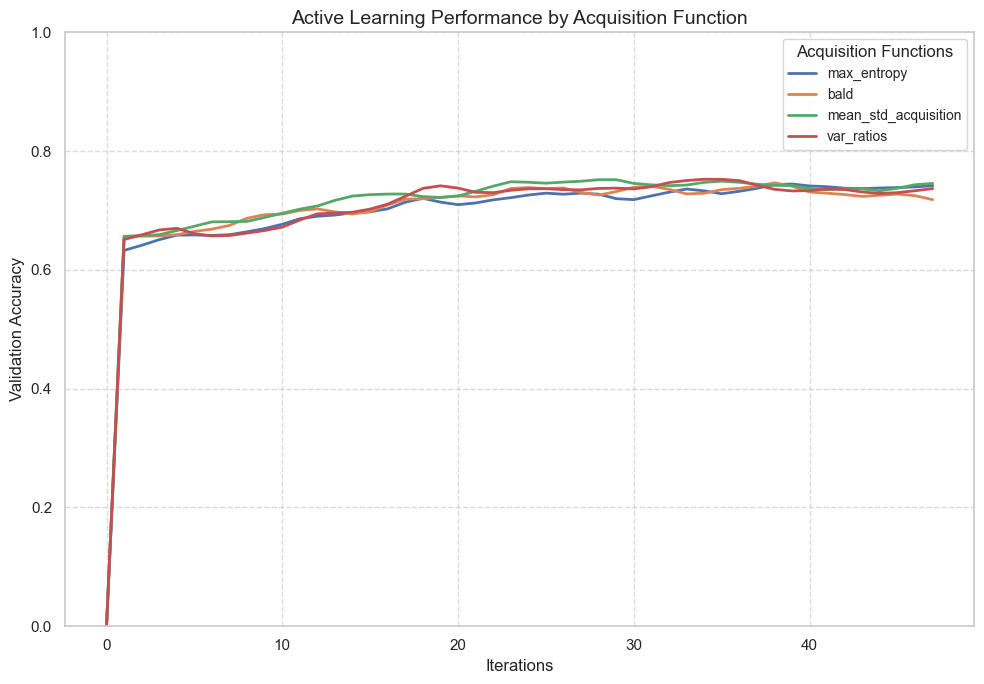

In [57]:
plot_results(data=results)

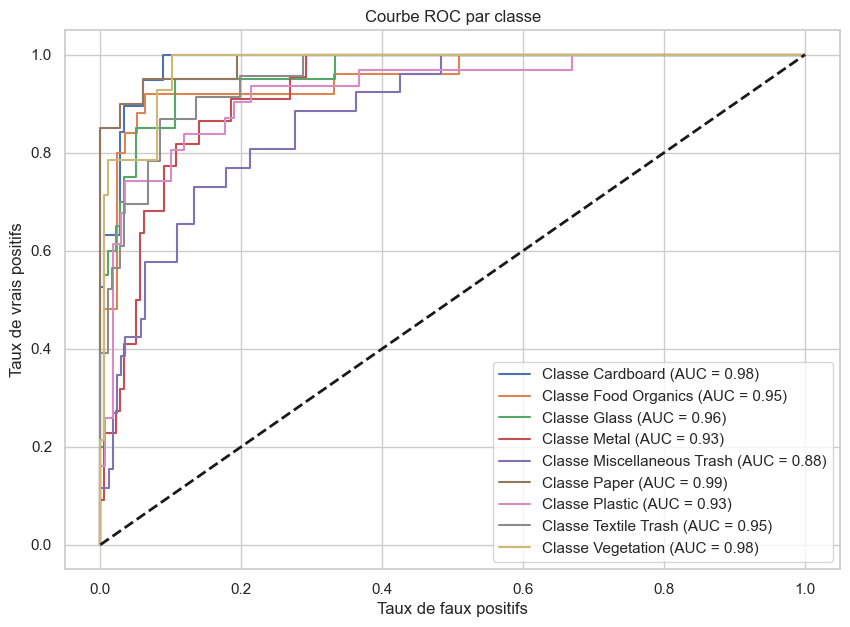

In [58]:
# Exemple : tracer la courbe ROC/AUC pour le dernier modèle entraîné (à adapter selon votre workflow)
# Ici, on suppose que 'estimator' est le dernier modèle entraîné et que X_test, y_test, idx_to_class sont définis
try:
    plot_auc_curve(estimator, X_test, y_test, idx_to_class)  # Appelle la fonction pour tracer la courbe ROC/AUC multi-classe
except Exception as e:
    print("Impossible de tracer la courbe AUC :", e)  # Affiche un message d'erreur si le tracé échoue


# Tableau de donnée necessaire

In [ ]:

# Définir les seuils d'accuracy à tester
accuracy_targets = [0.60, 0.65, 0.70]  # Seuils d'accuracy à atteindre pour l'analyse

# Charger les résultats pour chaque fonction d'acquisition
acq_func_files = {
    'max_entropy': 'max_entropy.npy',  # Résultats pour la fonction max_entropy
    'bald': 'bald.npy',               # Résultats pour la fonction bald
    'mean_std_acquisition': 'mean_std_acquisition.npy',  # Résultats pour la fonction mean_std_acquisition
    'var_ratios': 'var_ratios.npy',   # Résultats pour la fonction var_ratios
}

results_dir = 'result_npy'  # Dossier où se trouvent les fichiers de résultats
acquired_per_iter = N_QUERY  # Nombre d'images acquises à chaque itération d'apprentissage actif
initial_size = len(X_initial)  # Taille initiale du jeu de données labellisé

summary = {thresh: {} for thresh in accuracy_targets}  # Dictionnaire pour stocker le nombre d'images nécessaires pour chaque seuil

for acq_name, filename in acq_func_files.items():
    path = os.path.join(results_dir, filename)  # Chemin complet du fichier de résultats
    if not os.path.exists(path):
        print(f"Fichier manquant pour {acq_name}: {filename}")  # Avertir si le fichier n'existe pas
        continue
    acc_curve = np.load(path)  # Charger la courbe d'accuracy
    for thresh in accuracy_targets:
        # Trouver la première itération où l'accuracy dépasse le seuil
        idx = np.argmax(acc_curve >= thresh)
        if acc_curve[idx] < thresh:
            summary[thresh][acq_name] = 'Non atteint'  # Le seuil n'a jamais été atteint
        else:
            # Nombre total d'images acquises = initial + (itération * batch)
            n_acquired = initial_size + idx * acquired_per_iter
            summary[thresh][acq_name] = n_acquired  # Stocker le résultat




Tableau récapitulatif : Nombre d'images acquises pour atteindre chaque seuil d'accuracy
                    max_entropy  bald  mean_std_acquisition  var_ratios
Accuracy Threshold                                                     
0.60                        180   180                   180         180
0.65                        210   180                   180         190
0.70                        310   280                   280         290


In [49]:
# Générer le DataFrame pour affichage
summary_df = pd.DataFrame(summary).T  # Créer un tableau récapitulatif
summary_df.index.name = 'Accuracy Threshold'  # Nommer l'index
print("\nTableau récapitulatif : Nombre d'images acquises pour atteindre chaque seuil d'accuracy")
summary_df  # Afficher le tableau


Tableau récapitulatif : Nombre d'images acquises pour atteindre chaque seuil d'accuracy


,max_entropy,bald,mean_std_acquisition,var_ratios
Accuracy Threshold,,,,
0.60,180,180,180,180
0.65,210,180,180,190
0.70,310,280,280,290


In [ ]:
#  Exporter en image
summary_df.to_csv('summary_acquisition.csv')  # Exporter le tableau en fichier CSV